<Figure size 1200x600 with 0 Axes>

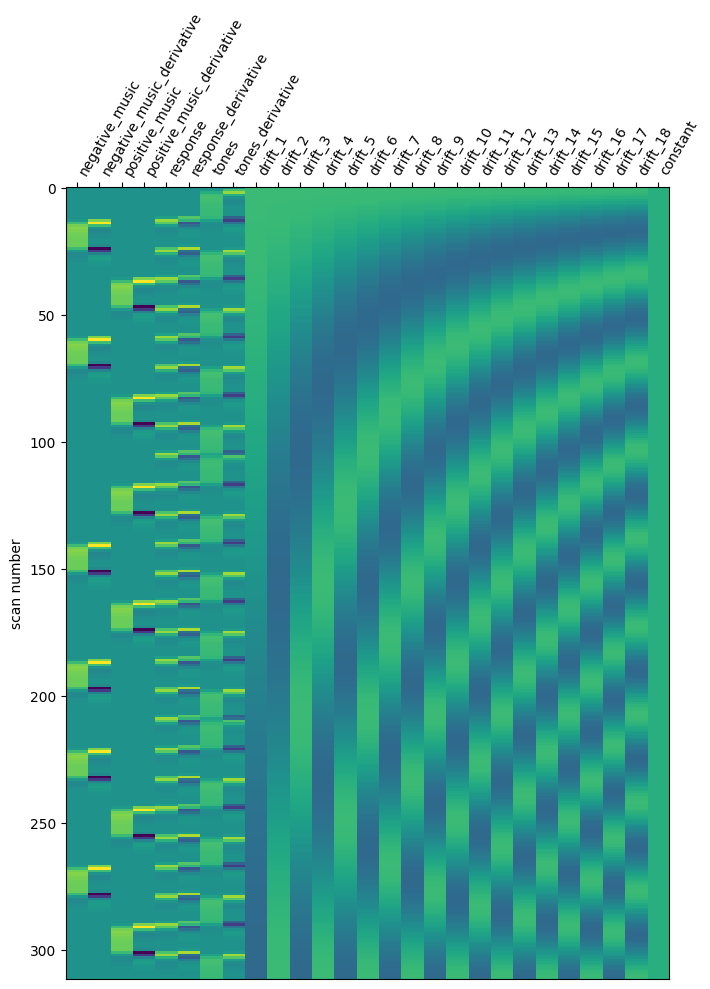

In [1]:
import os
import nibabel as nib
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_design_matrix():
   # Define paths relative to the src folder
    base_dir = os.path.join("..", "data", "raw", "sub-control01")  # Navigate up one directory and then into data
    preprocess_dir = os.path.join("..", "data", "preprocessed", "sub-control01")  # Preprocess folder
    figures_dir = os.path.join("..","results", "figures")  # Figures folder

    # Load the event files for each run
    events = [
        pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-1_events.tsv"), sep="\t"),
        pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-2_events.tsv"), sep="\t"),
        pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-3_events.tsv"), sep="\t")
    ]

    # Load the functional image to extract TR and run durations
    img = nib.load(os.path.join(base_dir, "func", "sub-control01_task-music_run-1_bold.nii.gz"))
    TR = img.header.get_zooms()[3]
    run_durations = [events[i]['onset'].iloc[-1] + events[i]['duration'].iloc[-1] for i in range(3)]

    # Adjust onsets based on cumulative duration of previous runs
    events[1]['onset'] += run_durations[0]
    events[2]['onset'] += run_durations[0] + run_durations[1]

    # Concatenate the events into a single DataFrame
    all_events = pd.concat(events, ignore_index=True)
    # Define the frame times for the entire concatenated session
    total_duration = sum(run_durations)
    frame_times = np.arange(0, total_duration, TR)

    # Generate the design matrix with slice timing correction
    design_matrix = make_first_level_design_matrix(
        frame_times,
        all_events,
        hrf_model='spm + derivative'
    )

    # Save the design matrix as a CSV file
    design_matrix.to_csv(os.path.join(preprocess_dir, "design_matrix.csv"), index=False)

    # Plot and save the design matrix
    plt.figure(figsize=(12, 6))
    plot_design_matrix(design_matrix)
    plt.savefig(os.path.join(figures_dir, "design_matrix.png"))
    plt.show()
    plt.close()  # Close the figure to free memory



if __name__ == "__main__":
    create_design_matrix()